In [1]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np
import pickle
import os

Load and Split the Data

In [2]:
def unPickleData(filename):
  with open(filename,'rb') as f: arr = pickle.load(f)
  return arr

def getDataPath(dirname,filename):
  return os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)),"processed_data", dirname,filename)

x_data = unPickleData(getDataPath("posts","X_posts.pkl"))
y_data = unPickleData(getDataPath("posts","Y_posts.pkl"))

In [3]:
X, y = [], []
Class0_max_count = 45000
for i in range(len(x_data)):
    if y_data[i] == 0: 
        if Class0_max_count > 0:
            X.append(x_data[i])
            y.append(y_data[i])
            Class0_max_count -= 1 
    else:
        X.append(x_data[i])
        y.append(y_data[i])

np_y = np.array(y)
print("class 0:", len(np_y[np_y==0]))
print("class 1:", len(np_y[np_y==1]))

class 0: 45000
class 1: 9114


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.6 , random_state= 42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5 , random_state= 42)

Logistic Regression Training & Hyperparameter Tuning

In [5]:
parameters = {'C':[0.001,0.01,0.1, 1 , 2 , 3]}
model = LogisticRegression(multi_class='ovr',solver="liblinear") 
linearClassifier = GridSearchCV(model, parameters, scoring = ['f1_micro','accuracy'], cv=5, refit='f1_micro' , verbose = 10)
linearClassifier.fit(X_train, y_train)

bestLinearClassifier = linearClassifier.best_estimator_

print("For Logistic Regression:")
print(f"Best Estimator: {linearClassifier.best_estimator_}")
print(f"F-measure = {linearClassifier.best_score_}")
print(f"Accuracy = {max(linearClassifier.cv_results_['mean_test_f1_micro'])}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=0.001.....................................................
[CV 1/5; 1/6] END C=0.001; accuracy: (test=0.830) f1_micro: (test=0.830) total time=   3.6s
[CV 2/5; 1/6] START C=0.001.....................................................
[CV 2/5; 1/6] END C=0.001; accuracy: (test=0.830) f1_micro: (test=0.830) total time=   3.4s
[CV 3/5; 1/6] START C=0.001.....................................................
[CV 3/5; 1/6] END C=0.001; accuracy: (test=0.830) f1_micro: (test=0.830) total time=   3.7s
[CV 4/5; 1/6] START C=0.001.....................................................
[CV 4/5; 1/6] END C=0.001; accuracy: (test=0.830) f1_micro: (test=0.830) total time=   3.7s
[CV 5/5; 1/6] START C=0.001.....................................................
[CV 5/5; 1/6] END C=0.001; accuracy: (test=0.830) f1_micro: (test=0.830) total time=   3.6s
[CV 1/5; 2/6] START C=0.01.................................................

Testing

In [6]:
y_pred = bestLinearClassifier.predict(X_test)

print(sklearn.metrics.classification_report(y_test,y_pred))
print(f"Accuracy = {sklearn.metrics.accuracy_score(y_test, y_pred)}")
print(f"f-measure = {sklearn.metrics.f1_score(y_test, y_pred, average='macro')}")

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9018
           1       0.80      0.42      0.55      1805

    accuracy                           0.89     10823
   macro avg       0.85      0.70      0.74     10823
weighted avg       0.88      0.89      0.87     10823

Accuracy = 0.8860759493670886
f-measure = 0.7439079750032015


Saving the model

In [7]:
def getSavedModelPath(dirname,filename):
  return os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)),"savedModels", dirname,filename)

with open(getSavedModelPath("posts","LogisticRegression.pkl"), 'wb') as f:
    pickle.dump(bestLinearClassifier,f)

Confusion Matrix

Confusion matrix, without normalization
[[8827  191]
 [1042  763]]
Normalized confusion matrix
[[0.97882014 0.02117986]
 [0.57728532 0.42271468]]


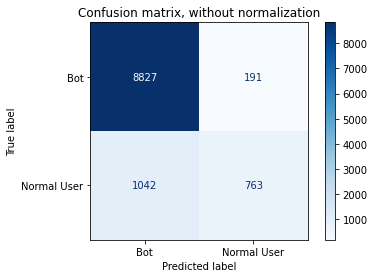

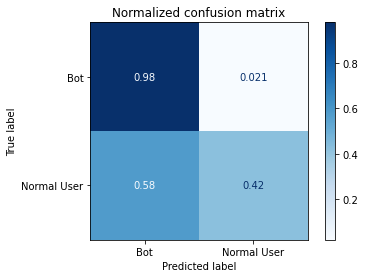

In [8]:
import matplotlib.pyplot as plot
from sklearn.metrics import ConfusionMatrixDisplay

title_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        bestLinearClassifier,
        X_test,
        y_test,
        display_labels=["Bot" , "Normal User"],
        cmap=plot.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

    print(title)
    print(display.confusion_matrix)

plot.show()


Learning Curve

[learning_curve] Training set sizes: [  292   882  1472  2063  2653  3244  3834  4424  5015  5605  6196  6786
  7376  7967  8557  9147  9738 10328 10919 11509 12099 12690 13280 13871
 14461 15051 15642 16232 16822 17413 18003 18594 19184 19774 20365 20955
 21546 22136 22726 23317 23907 24497 25088 25678 26269 26859 27449 28040
 28630 29221]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 24.0min finished


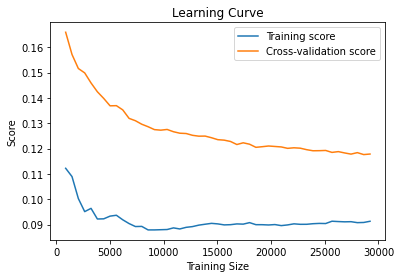

In [9]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_size, train_score, test_scores = learning_curve(bestLinearClassifier, X_train, y_train, cv = 10, scoring='accuracy', n_jobs=1, train_sizes=np.linspace(0.01, 1, 50), verbose=1)
mean_train = np.mean(train_score , axis = 1)
mean_test = np.mean(test_scores , axis = 1)
plt.plot(train_size, 1-mean_train, label='Training score')
plt.plot(train_size, 1-mean_test, label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()